<a href="https://colab.research.google.com/github/tejeshb/Satellite_Imagery_ML/blob/main/Satellite_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn import metrics



In [ ]:
# Load data

In [ ]:
# Import PyDrive and associated libraries.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
 #Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
data = np.load('/content/drive/MyDrive/MOOC_dataset.npz') # You can download the dataset from www.wekeo.eu

In [ ]:
files = data.files
print(files)

['image', 'label']


In [ ]:
print('Shape - "Image" item: ' + str(data['image'].shape))
print('Shape - "Label" item: ' + str(data['label'].shape))

Shape - "Image" item: (2805, 128, 128)
Shape - "Label" item: (2805,)


In [ ]:
data['image'][1500].shape

(128, 128)

Text(0.5, 1.0, 'Ship Class: Container')

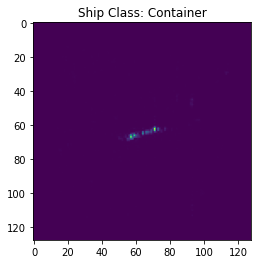

In [ ]:
plt.imshow(data['image'][1200])
plt.title("Ship Class: Container")

Text(0.5, 1.0, 'Ship Class: Tanker')

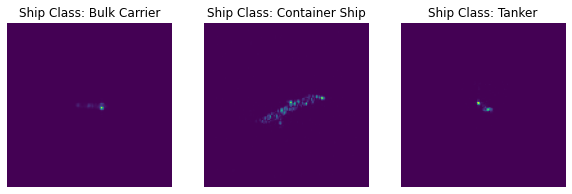

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
#from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = data['image'][1,:,:]
Image2 = data['image'][1500,:,:]
Image3 = data['image'][2800,:,:]


# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Ship Class: Bulk Carrier")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Ship Class: Container Ship")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Ship Class: Tanker")



In [ ]:
# Images and Labels
X = data['image']
y = data['label']

In [ ]:
# Instantiate the neural net

inputs = tf.keras.layers.Input(shape=(128,128,1))
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Now we are able to instantiate the VGG16 model. The tensorflow Keras API offers under tensorflow.keras.applications a set of models (canned architectures) with pre-trained weights and VGG16 is one of them. You can instantiate a VGG16 model with the following keyword arguments:

include_top=False - we do not want to include the three fully-connected layers at the top of the network

weights=None - by setting weights to None, we choose random initialization

input_tensor=inputs - The input tensor is the inputs tensor created in the previous step
pooling='avg' - global average pooling will be applied to the output of the last convolutional block and this means that the output of the model will be a two-dimensional tensor

NOTE:
Fully connected layers: By default, the algorithm would include three fully connected layers on top, but for training purposes, the example does not include them to give you an opportunity to play with hyperparameters in the next step.

In [ ]:
vgg = VGG16(include_top=False,
            weights=None,
            input_tensor=inputs,
            pooling='avg')
vgg

In [ ]:
inp = vgg.input
inp

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'input_1')>

In [ ]:
dense1 = tf.keras.layers.Dense(512, activation='relu')(vgg.output)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)

dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)
pred

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>

In [ ]:
model = tf.keras.Model(inp, pred)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')

model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model

In [ ]:
# Split data - Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2103, 128, 128)
(702, 128, 128)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
check = tf.keras.callbacks.ModelCheckpoint('./vgg.h5',
                                           monitor='val_accuracy',
                                           verbose=0,
                                           save_best_only=True, mode='auto')

In [ ]:
log = tf.keras.callbacks.CSVLogger('./vgg.txt')

In [ ]:
import multiprocessing
from timeit import default_timer as timer

start = timer()
cpu_count = multiprocessing.cpu_count()
print(f"cpu: {cpu_count} found")

model.fit(X_train, y_train,
          batch_size=12,
          epochs=50,
#          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          steps_per_epoch = 25,
          max_queue_size=10,
          workers=cpu_count,
          use_multiprocessing=cpu_count > 1,
          callbacks=[check, log])

end = timer()
print('Elapsed time: ' + str(end - start))

cpu: 2 found
Epoch 1/50
25/25 [==============================] - 41s 305ms/step - loss: 1.0972 - accuracy: 0.4067 - val_loss: 1.0955 - val_accuracy: 0.4017
Epoch 2/50
25/25 [==============================] - 6s 234ms/step - loss: 1.0965 - accuracy: 0.3867 - val_loss: 1.0935 - val_accuracy: 0.4017
Epoch 3/50
25/25 [==============================] - 6s 238ms/step - loss: 1.0890 - accuracy: 0.4367 - val_loss: 1.0916 - val_accuracy: 0.4017
Epoch 4/50
25/25 [==============================] - 6s 235ms/step - loss: 1.0912 - accuracy: 0.4000 - val_loss: 1.0900 - val_accuracy: 0.4017
Epoch 5/50
25/25 [==============================] - 6s 235ms/step - loss: 1.0939 - accuracy: 0.3833 - val_loss: 1.0894 - val_accuracy: 0.4017
Epoch 6/50
25/25 [==============================] - 6s 240ms/step - loss: 1.0935 - accuracy: 0.3800 - val_loss: 1.0893 - val_accuracy: 0.4017
Epoch 7/50
25/25 [==============================] - 6s 236ms/step - loss: 1.0771 - accuracy: 0.4733 - val_loss: 1.0884 - val_accuracy:

In [ ]:
model = load_model('./vgg.h5')

_, test_acc = model.evaluate(X_test, y_test)

print('Test_acc: %.4f' % test_acc)

22/22 [==============================] - 9s 236ms/step - loss: 1.0955 - accuracy: 0.4017
Test_acc: 0.4017
